## NX-414: Brain-like computation and intelligence
Notebook prepared by Alessandro Marin Vargas

# Week 6 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2025

You are required to submit your mini-projects by midnight on 07/05/25. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

Then in the jupyter notebook Select Kernel and paste the links

In [1]:
%ls
%cd NX-414
%ls

gnn4eeg/    miniconda3/             NX-414/       utils.py
IT_data.h5  miniconda_installer.sh  __pycache__/
/home/berlengh/NX-414
 best_convnext_head_deep.pt   part3.py           'Week 1'/           Week7/
 best_model.pth               __pycache__/       'Week 2'/          'Week 8'/
 best_resnet50_deephead.pt    README.md          'Week 4'/
 final.ipynb                  resnet_pca_cache/   Week6/
 IT_data.h5                   utils.py            week6Part2.ipynb


/home/berlengh/miniconda3/envs/nx414/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# %pip install transformers
# %pip install seaborn
# %pip install pynvml

In [3]:
from utils import load_it_data, visualize_img
import gdown

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import explained_variance_score

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

In [4]:
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "../IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=2ae1b0e9-9422-4a55-8015-9f66f3c015ce
To: /home/berlengh/IT_data.h5
100%|██████████████████████████████████████████████████████████████████████| 384M/384M [00:03<00:00, 123MB/s]


'../IT_data.h5'

### Load the data

In [5]:
path_to_data = ''## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [6]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The train dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The train dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


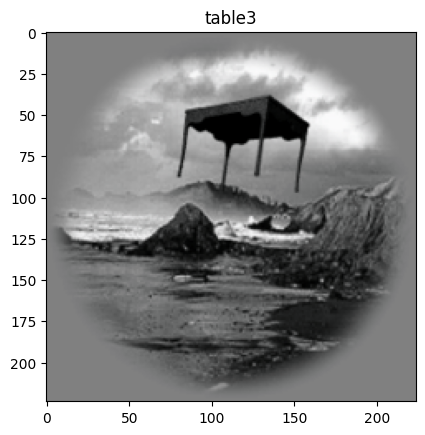

In [7]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

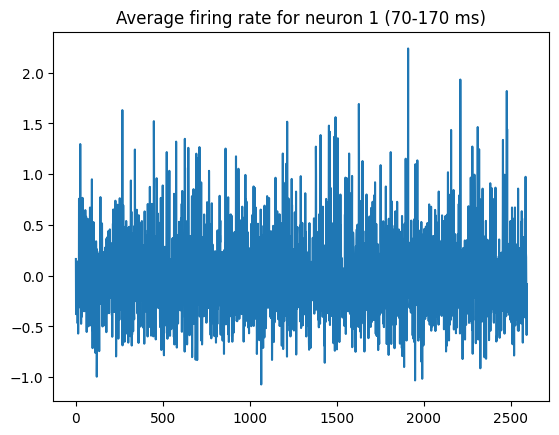

In [8]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

## Part 1: Predict the neural activity from pixels

##### Develop a linear regression model that predict the neural activity from pixels.
You can try out different types of linear regression (ridge, least-square regression)

In [9]:
# Step 1: Flatten and normalize image pixels
X_train = stimulus_train.reshape(len(stimulus_train), -1)
X_val = stimulus_val.reshape(len(stimulus_val), -1)

scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Step 2: Linear Regression model
lr = LinearRegression()
lr.fit(X_train, spikes_train)

# Predict on validation set
Y_pred_linear = lr.predict(X_val)

##### Evaluate your prediction (Check both the correlation and explained variance for each neuron). Plot the distribution for the explained variance across neurons.

In [10]:
explained_variances = []
correlations = []

# Obtain evaluation metrics (correlation and explained variance) for each neuron 
for i in range(spikes_val.shape[1]):
    y_true = spikes_val[:, i]
    y_pred = Y_pred_linear[:, i]
    
    ev = explained_variance_score(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    
    explained_variances.append(ev)
    correlations.append(corr)

In [11]:
def plot_distribution(ev_data, corr_data, colors, suptitle):
    """
    Plot side-by-side distributions of explained variance and correlation with KDE, mean, and standard deviation.

    Parameters
    ----------
    ev_data : array-like
        Array of explained variance values to plot.
    
    corr_data : array-like
        Array of correlation values to plot.
    
    colors : list of str
        A list of two color strings used to color the histograms for `ev_data` and `corr_data` respectively.
    
    suptitle : str
        Title for the entire figure.

    Returns
    -------
    None
        The function displays the plot and does not return anything.
    """
    mean_data_ev, std_data_ev = np.mean(ev_data), np.std(ev_data)
    mean_data_corr, std_data_corr = np.mean(corr_data), np.std(corr_data)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    sns.histplot(ev_data, kde=True, stat="density", bins=30, color=colors[0], edgecolor="black", alpha=0.5, ax=axes[0])
    axes[0].axvline(mean_data_ev, color='red', linestyle='--', label=f'Mean = {mean_data_ev:.4f}')
    axes[0].axvspan(mean_data_ev - std_data_ev, mean_data_ev + std_data_ev, color='orange', alpha=0.2, label=f'± Std = {std_data_ev:.4f}')
    axes[0].set_title("Explained Variance distribution (with KDE)")
    axes[0].set_xlabel('Explained Variance')
    axes[0].set_ylabel("Density")
    axes[0].legend()
    
    sns.histplot(corr_data, kde=True, stat="density", bins=30, color=colors[1], edgecolor="black", alpha=0.5, ax=axes[1])
    axes[1].axvline(mean_data_corr, color='red', linestyle='--', label=f'Mean = {mean_data_corr:.4f}')
    axes[1].axvspan(mean_data_corr - std_data_corr, mean_data_corr + std_data_corr, color='orange', alpha=0.2, label=f'± Std = {std_data_corr:.4f}')
    axes[1].set_title("Correlation distribution (with KDE)")
    axes[1].set_xlabel("Correlation")
    axes[1].legend()

    plt.suptitle(suptitle, fontsize = 15)    
    plt.tight_layout()
    plt.show()
    
    

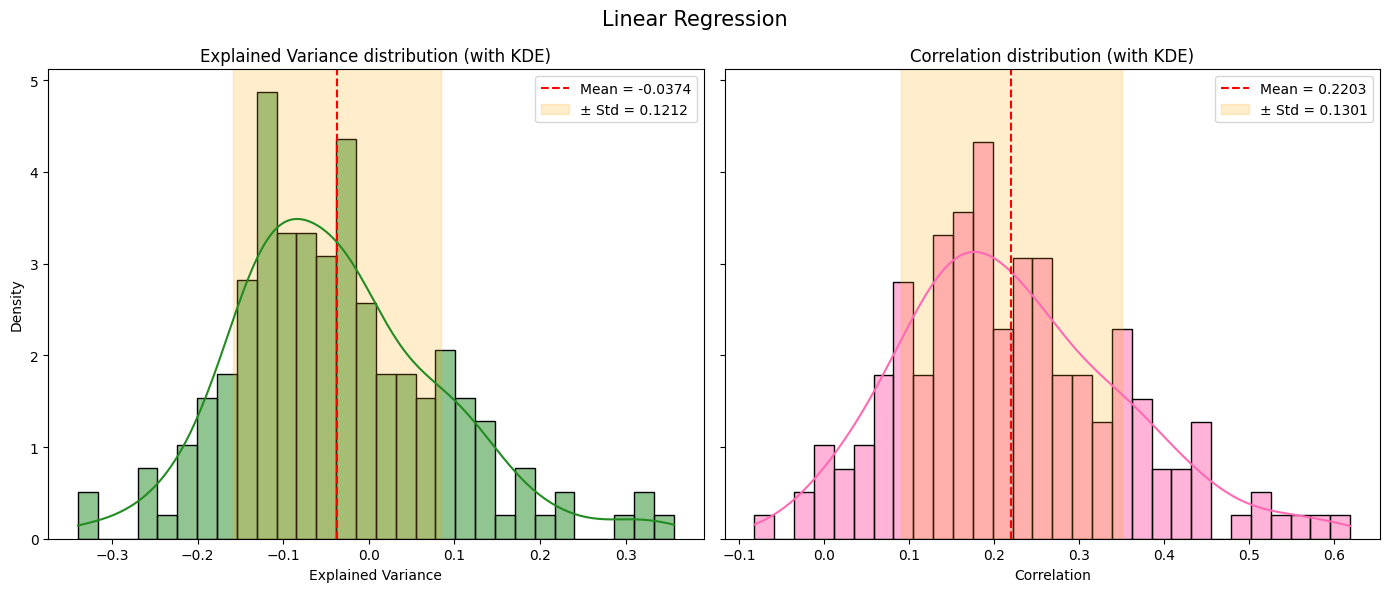

In [12]:
colors = ('forestgreen', 'hotpink')
plot_distribution(explained_variances, correlations, colors, 'Linear Regression')

In [13]:
# Ridge regression with default alpha=1.0
a_value = 1.0
ridge = Ridge(alpha=a_value)
ridge.fit(X_train, spikes_train)
Y_pred_ridge = ridge.predict(X_val)

# Evaluate
explained_variances_ridge = []
correlations_ridge = []

for i in range(spikes_val.shape[1]):
    y_true = spikes_val[:, i]
    y_pred = Y_pred_ridge[:, i]
    
    ev = explained_variance_score(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    
    explained_variances_ridge.append(ev)
    correlations_ridge.append(corr)

/home/berlengh/miniconda3/envs/nx414/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=4.20864e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)


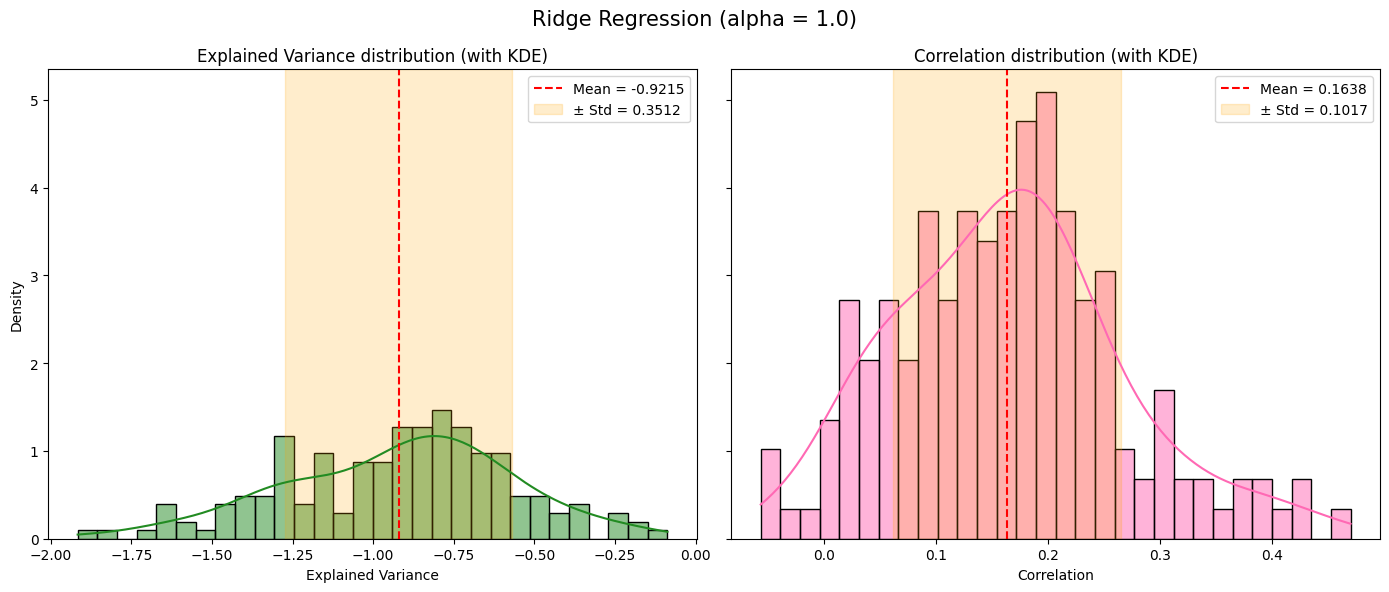

In [14]:
colors = ('forestgreen', 'hotpink')
plot_distribution(explained_variances_ridge, correlations_ridge, colors, f'Ridge Regression (alpha = {a_value})')

##### Predicting from pixels is very hard and the model is likely to overfit. An image is very high-dimensional, try to retain the corresponding 1000 PCs and use them to predict the neural activity. 

In [15]:
pca = PCA(n_components=1000)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, spikes_train)
Y_pred_pca = lr_pca.predict(X_val_pca)

In [16]:
# Evaluate
explained_variances_pca = []
correlations_pca = []

for i in range(spikes_val.shape[1]):
    y_true = spikes_val[:, i]
    y_pred = Y_pred_pca[:, i]
    
    ev = explained_variance_score(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    
    explained_variances_pca.append(ev)
    correlations_pca.append(corr)

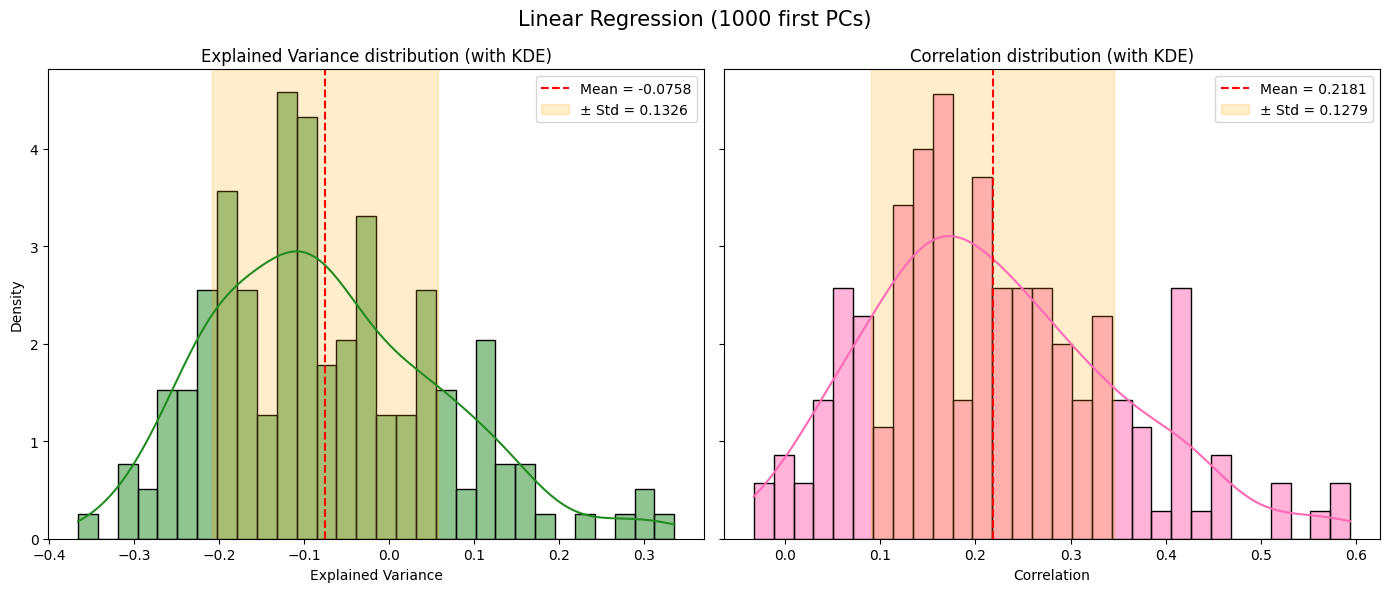

In [17]:
colors = ('forestgreen', 'hotpink')
plot_distribution(explained_variances_pca, correlations_pca, colors, f'Linear Regression (1000 first PCs)')

##### Can we improve the prediction? Using the ridge regression, find the best parameter with cross-fold validation (remember to split the data keeping the same distribution of classes between the train and validation set). Does it get better?

In [ ]:
alphas =  [0.01, 0.1, 1, 10, 100]
kf = KFold(n_splits=5, shuffle=True, random_state=42)  
mean_scores = []

X_train = stimulus_train.reshape(len(stimulus_train), -1)
X_val = stimulus_val.reshape(len(stimulus_val), -1)

for alpha in alphas:
    fold_scores = []
    for train_idx, val_idx in kf.split(X_train):
        Xtr, Xval = X_train[train_idx], X_train[val_idx]
        Ytr, Yval = spikes_train[train_idx], spikes_train[val_idx]

        # Scale first
        scaler = StandardScaler()
        Xtr_scaled = scaler.fit_transform(Xtr)
        Xval_scaled = scaler.transform(Xval)

        # PCA on training only
        pca = PCA(n_components=1000)
        Xtr_pca = pca.fit_transform(Xtr_scaled)
        Xval_pca = pca.transform(Xval_scaled)

        # Ridge Regression
        model = Ridge(alpha=alpha)
        model.fit(Xtr_pca, Ytr)
        Ypred = model.predict(Xval_pca)

        # Score: average explained variance across all neurons
        ev = explained_variance_score(Yval, Ypred, multioutput='uniform_average')
    
        fold_scores.append(ev)

    mean_scores.append(np.mean(fold_scores))

    print(f"Alpha={alpha}, CV explained variance: {np.mean(mean_scores):.4f}")

# Best alpha
best_alpha = alphas[np.argmax(mean_scores)]
print("\nBest alpha:", best_alpha)

Alpha=0.01, CV explained variance: -0.1615
Alpha=0.1, CV explained variance: -0.1593
Alpha=1, CV explained variance: -0.1608
Alpha=10, CV explained variance: -0.1598
Alpha=100, CV explained variance: -0.1591

Best alpha: 100


In [19]:
# Final PCA + Ridge training using best alpha
pca_final = PCA(n_components=1000)
X_train_pca_final = pca_final.fit_transform(X_train)
X_val_pca_final = pca_final.transform(X_val)

ridge_final = Ridge(alpha=best_alpha)
ridge_final.fit(X_train_pca_final, spikes_train)
Y_pred_final = ridge_final.predict(X_val_pca_final)

In [20]:
# Evaluate
ev_pca_ridge = []
corr_pca_ridge = []

for i in range(spikes_val.shape[1]):
    y_true = spikes_val[:, i]
    y_pred = Y_pred_final[:, i]
    
    ev = explained_variance_score(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    
    ev_pca_ridge.append(ev)
    corr_pca_ridge.append(corr)


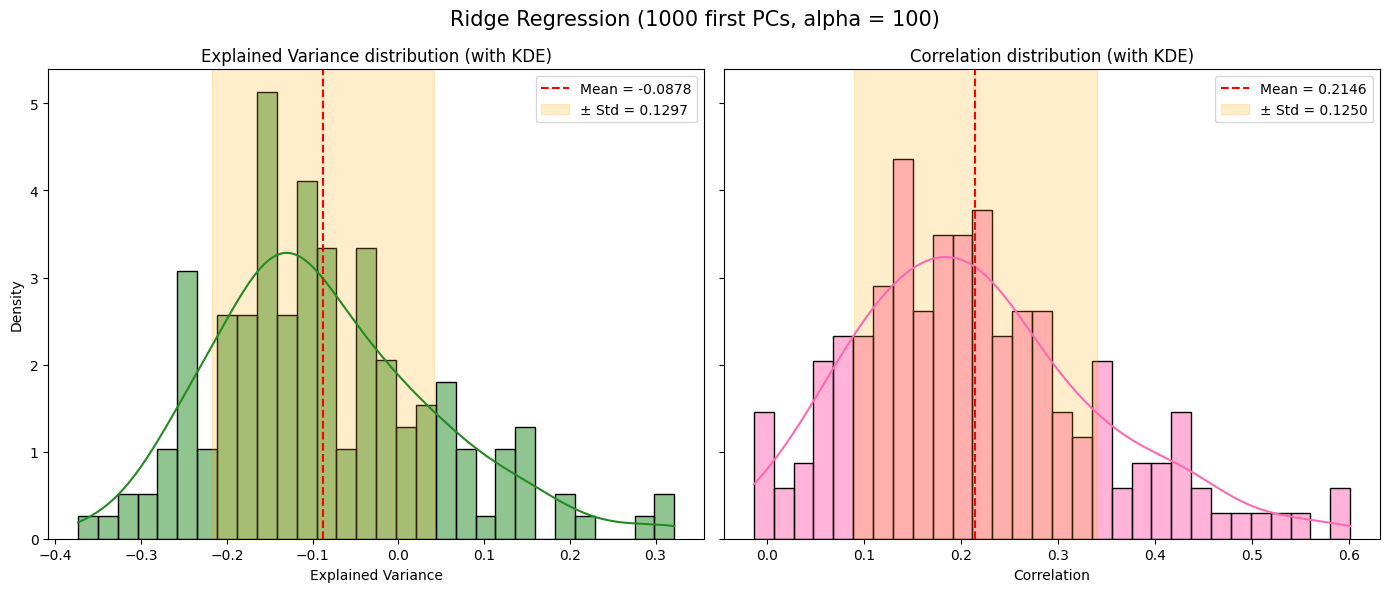

In [21]:
colors = ('forestgreen', 'hotpink')
plot_distribution(ev_pca_ridge, corr_pca_ridge, colors, f'Ridge Regression (1000 first PCs, alpha = {best_alpha})')

### Part 2: Predict the neural activity with the task-driven modeling approach

As you have seen in the class, the underlying hypothesis of task-driven modeling is that training the network to perform a relevant behavioral task makes the network to develop representations that resemble the ones of the biological brain. Let's test this hypothesis by loading a pre-trained ResNet50 model and use the activations of each layer to predict the neural activity. Follow these steps:

- Give as input to the network the stimuli and extract the corresponding activations of the following layers ['conv1','layer1','layer2','layer3','layer4','avgpool']
- Compute the 1000 PCs for each layer activation. (Careful that you don't want to store all activations together at the same time because it won't fit in the memory. Therefore, compute the activations and corresponding PCs for each layer and store only the computed PCs).
- Use the PCs of each layer to predict the neural activity using the linear regression models you developed before.
- Compute the goodness of fit using the correlation and explained variance metrics. Do you predict the neural activity better than before?
- Plot the distribution of explained variance with respect to the layer of the network (order them based on the depth). How does the neural activity changes across the model layers, can you make some statements about it?
- Compare the predictions that you obtained using one layer of the pretrained model and the one obtained using the same layer but from a randomly initialized model. Which network can better predict the neural activity and why?

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet50
resnet_pretrained = models.resnet50(pretrained=True).to(device)

resnet_pretrained.eval()


target_layers = ['conv1','layer1','layer2','layer3','layer4','avgpool']
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu().numpy()  # store on CPU
    return hook

# Register hooks for chosen layers
for name in target_layers:
    layer = dict([*resnet_pretrained.named_modules()])[name]
    layer.register_forward_hook(get_activation(name))

# Normalize and convert training images to tensors
stimuli_tensor = torch.tensor(stimulus_train).float() / 255.0
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).cuda()
imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).cuda()
stimuli_tensor = (stimuli_tensor.cuda() - imagenet_mean) / imagenet_std

# PCA setup
n_components = 1000
layer_pc_train = {}
layer_pcas = {}

# Batch processing (can adjust batch size for memory optimization)
batch_size = 16  # Adjust this according to GPU memory
num_batches = len(stimuli_tensor) // batch_size + (len(stimuli_tensor) % batch_size != 0)


with torch.no_grad():
    for layer_name in target_layers:
        print(f"\n⏳ Processing layer: {layer_name}")
        layer_outputs = []

        for batch_idx in tqdm(range(num_batches)):
            batch_start = batch_idx * batch_size
            batch_end = min((batch_idx + 1) * batch_size, len(stimuli_tensor))
            batch = stimuli_tensor[batch_start:batch_end]

            _ = resnet_pretrained(batch)  # feed batch to GPU
            act = activations[layer_name]  # comes back on CPU
            act_flat = act.reshape(act.shape[0], -1)
            layer_outputs.append(act_flat)

        X_layer = np.concatenate(layer_outputs, axis=0)  # shape: [N, D]
        print("📐 Running PCA...")
        pca = PCA(n_components=n_components)
        X_layer_pca = pca.fit_transform(X_layer)

        layer_pc_train[layer_name] = X_layer_pca
        layer_pcas[layer_name] = pca


/home/berlengh/miniconda3/envs/nx414/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/berlengh/miniconda3/envs/nx414/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



⏳ Processing layer: conv1


100%|██████████████████████████████████████████████████████████████████████| 162/162 [00:10<00:00, 16.02it/s]


📐 Running PCA...


KeyboardInterrupt: 

In [ ]:
results = {
        'ev': [],
        'corr': []
    }

print(f"\n=== Linear Regression ===")

for layer in target_layers:
    print(f"→ Layer: {layer_name}")

    activations.clear()
    with torch.no_grad():
        _ = resnet_pretrained(stimuli_tensor)

    # Flatten activations and move to CPU for PCA
    layer_acts = activations[layer]
    flat_acts = layer_acts.view(layer_acts.size(0), -1).cpu().numpy()
    #flat_acts = layer_acts.view(layer_acts.size(0), -1).detach().cpu().numpy()

    del layer_acts
    torch.cuda.empty_cache()
    
    # Compute PCA
    pca = PCA(n_components=1000)
    pcs = pca.fit_transform(flat_acts)

    # OLS
    reg = LinearRegression()
    reg.fit(pcs, spikes_val) 
    pred = reg.predict(pcs)
    
    ev = explained_variance_score(spikes_val, pred, multioutput='raw_values')
    corr = np.array([np.corrcoef(spikes_val[:, i], pred[:, i])[0, 1] for i in range(spikes_val.shape[1])])
    
    results['ev'].append(ev)
    results['corr'].append(corr)
    
    print(f'Mean EV: {np.mean(ev):.3f} - Mean Corrlation : {np.mean(corr):.3f}')

# save results as dataframe
results_df = pd.DataFrame.from_dict(results)
results_df.to_csv('results/linear_regression.csv')


=== Linear Regression ===
→ Layer: avgpool


OutOfMemoryError: CUDA out of memory. Tried to allocate 7.75 GiB. GPU 0 has a total capacity of 31.74 GiB of which 3.15 GiB is free. Process 416992 has 3.40 GiB memory in use. Including non-PyTorch memory, this process has 25.19 GiB memory in use. Of the allocated memory 19.00 GiB is allocated by PyTorch, and 5.83 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
plt.figure(figsize=(8, 5))

for reg_name in results:
    mean_r2s = [np.mean(results[reg_name][layer]['r2']) for layer in target_layers]
    plt.plot(target_layers, mean_r2s, marker='o', label=f"{reg_name.upper()}")

plt.title("Explained Variance vs Layer Depth")
plt.xlabel("ResNet Layer")
plt.ylabel("Mean R²")
plt.grid(True)
plt.legend()
plt.show()

In [18]:
resnet_rand = models.resnet50(weights=None).cuda()
resnet_rand.eval()

# Hook setup for layer3 only
layer_to_check = 'layer3'
activations_rand = {}

def get_activation_rand(name):
    def hook(model, input, output):
        activations_rand[name] = output.detach().cpu().numpy()
    return hook

layer = dict([*resnet_rand.named_modules()])[layer_to_check]
layer.register_forward_hook(get_activation_rand(layer_to_check))

# Normalize val data and push to GPU
stimuli_val_tensor = torch.tensor(stimulus_val).float() / 255.0
stimuli_val_tensor = (stimuli_val_tensor.cuda() - imagenet_mean) / imagenet_std

# Get PCs for validation set using pretrained model's PCA
layer_outputs_rand = []

with torch.no_grad():
    for i in tqdm(range(len(stimuli_val_tensor)), desc="🌀 Extracting from Random ResNet"):
        _ = resnet_rand(stimuli_val_tensor[i:i+1])
        act = activations_rand[layer_to_check]
        act_flat = act.reshape(act.shape[0], -1)
        layer_outputs_rand.append(act_flat[0])

X_val_rand_raw = np.stack(layer_outputs_rand)
X_val_rand_pca = layer_pcas[layer_to_check].transform(X_val_rand_raw)  # use pretrained PCA

# Train model on pretrained PCs
X_train = layer_pc_train[layer_to_check]
y_train = spikes_train
X_val = X_val_rand_pca
y_val = spikes_val

# Train and evaluate
print(f"\n=== Random ResNet @ {layer_to_check} ===")

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

ev = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')
corr = np.array([np.corrcoef(spikes_val[:, i], y_pred[:, i])[0, 1] for i in range(spikes_val.shape[1])])

print(f"Mean EV = {np.mean(ev):.3f}, Mean Correlation = {np.mean(corr):.3f}")

🌀 Extracting from Random ResNet: 100%|███████████████████████████████████| 288/288 [00:01<00:00, 222.97it/s]



=== Random ResNet @ layer3 ===
Mean EV = -1.206, Mean Correlation = 0.044


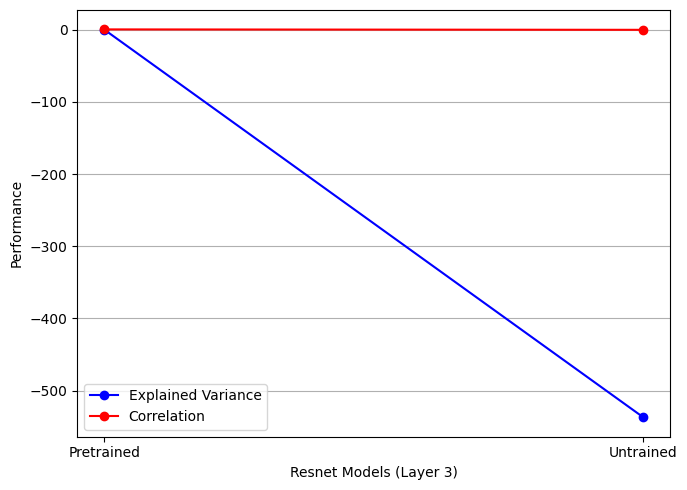

In [23]:
#---- later, take best layer and compare with no model for both metrics
# plot mean +- std + of ev and correlation 
target_layers = ['conv1','layer1','layer2','layer3','layer4','avgpool']

x = np.arange(2)
######################### REPLACE WITH THE ACTUAL DATA
# Means and standard deviations
EV_mean = np.array([0.398, -537.1]) #trained, then untrained
EV_std  = np.array([0, 0]) #trained, then untrained

corr_mean = np.array([0.623, 0.034]) #trained, then untrained
corr_std  = np.array([0, 0]) #trained, then untrained
#######################
fig = plt.figure(figsize=(7, 5))

# Explained Variance
plt.plot(x, EV_mean, label="Explained Variance", color="blue", marker='o')
plt.fill_between(x,
                 EV_mean - EV_std,
                 EV_mean + EV_std,
                 color="blue", alpha=0.2)
# Correlation
plt.plot(x, corr_mean, label="Correlation", color="red", marker='o')
plt.fill_between(x,
                 corr_mean - corr_std,
                 corr_mean + corr_std,
                 color="red", alpha=0.2)
plt.xticks(x, ['Pretrained', 'Untrained'])
plt.xlabel(f"Resnet Models (Layer 3)")
plt.ylabel("Performance")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Predict the neural activity using a data-driven approach

In the first part of the project, you have predicted the neural activity either from pixels or from the activations of a pre-trained neural network model. Here, your objective is to build and train a shallow convolutional neural network to predict the IT neural activity.

Follow these steps:
- Create the dataloader
- Define the model (Shallow CNN with 2/3 layers)
- Define the loss function (MSE) and the optimizer
- Build the training script and train your model
- Evaluate the predictions of your model. 
- Compare the neural predictions with the ones achieved by the task-trained neural network model. Which one can better predict the neural activity?

In [10]:
X_train_tensor = torch.tensor(stimulus_train, dtype=torch.float32) / 255.0
y_train_tensor = torch.tensor(spikes_train, dtype=torch.float32)

X_val_tensor = torch.tensor(stimulus_val, dtype=torch.float32) / 255.0
y_val_tensor = torch.tensor(spikes_val, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 64  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [11]:
class ShallowCNN(nn.Module):
    def __init__(self, n_neurons):
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, n_neurons)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # flatten
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [12]:
n_neurons = y_train_tensor.shape[1]
model = ShallowCNN(n_neurons).cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [24]:
epochs = 12
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")

Epoch 1/12 | Train Loss: 0.0983 | Val Loss: 0.1189
Epoch 2/12 | Train Loss: 0.0972 | Val Loss: 0.1207
Epoch 3/12 | Train Loss: 0.0961 | Val Loss: 0.1211
Epoch 4/12 | Train Loss: 0.0949 | Val Loss: 0.1209
Epoch 5/12 | Train Loss: 0.0938 | Val Loss: 0.1218
Epoch 6/12 | Train Loss: 0.0928 | Val Loss: 0.1213
Epoch 7/12 | Train Loss: 0.0919 | Val Loss: 0.1226
Epoch 8/12 | Train Loss: 0.0912 | Val Loss: 0.1237
Epoch 9/12 | Train Loss: 0.0900 | Val Loss: 0.1241
Epoch 10/12 | Train Loss: 0.0888 | Val Loss: 0.1238
Epoch 11/12 | Train Loss: 0.0879 | Val Loss: 0.1242
Epoch 12/12 | Train Loss: 0.0877 | Val Loss: 0.1273


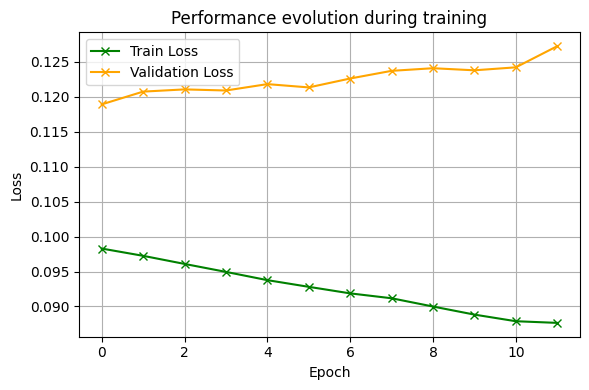

In [ ]:
x = np.arange(epochs)
fig = plt.figure(figsize=(6, 4))

# Explained Variance
plt.plot(x, train_losses, label="Train Loss", color="green", marker='x')
# Correlation
plt.plot(x, val_losses, label="Validation Loss", color="orange", marker='x')

plt.title('Performance evolution during training')
plt.xlabel(f"Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
model.eval()
y_val_pred = []

with torch.no_grad():
    for X_batch, _ in val_loader:
        outputs = model(X_batch.cuda()).cpu()
        y_val_pred.append(outputs)

y_val_pred = torch.cat(y_val_pred).numpy()
y_val = y_val_tensor.numpy()

# Per-neuron metrics
ev_scores, corr_scores = [], []
for i in range(y_val.shape[1]):
    corr_scores.append(np.corrcoef(y_val[:, i], y_val_pred[:, i])[0, 1])
    ev_scores.append(explained_variance_score(y_val[:, i], y_val_pred[:, i]))
print('======= Average performance across 168 neurons =======')
print(f"Explained Variance: {np.mean(ev_scores):.4f}, Correlation: {np.mean(corr_scores):.4f}")

======= Average performance across 168 neurons =======
Explained Variance: 0.1079, Correlation: 0.3503


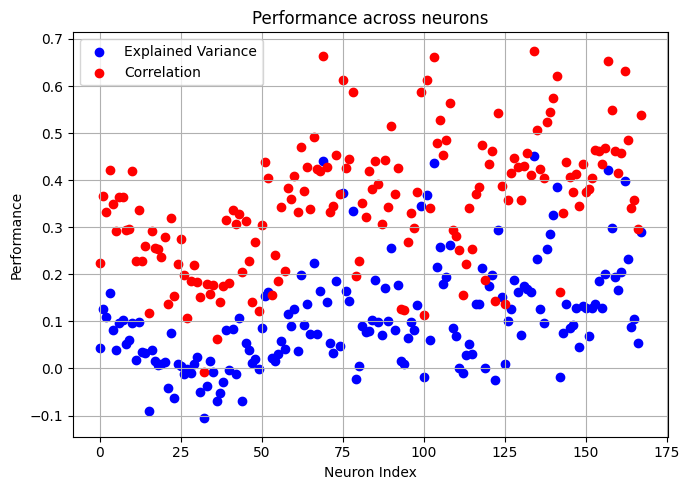

In [34]:
x = np.arange(168)
fig = plt.figure(figsize=(7, 5))
# Explained Variance
plt.scatter(x, ev_scores, label="Explained Variance", color="blue", marker='o')
# Correlation
plt.scatter(x, corr_scores, label="Correlation", color="red", marker='o')

plt.title('Performance across neurons')
plt.xlabel(f"Neuron Index")
plt.ylabel("Performance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

> The evaluation metrics used (Explained Variance and Correlation) show that the performance of task-driven approach allows to predict IT neuron activity much more accurately than using a data-driven approach.

# Challenge: Develop the most accurate model for predicting IT neural activity.

Throughout the mini-projects, you have acquired knowledge on predicting neural activity through both task-driven and data-driven approaches. You are now free to explore both approaches to create the most effective model for predicting neural activity. Here are some suggestions to help guide your exploration:
- Optimize your current models by adjusting hyperparameters and implementing different regularizations.
- Utilize different pretrained models.
- Employ a pretrained neural network and finetune it for predicting the neural activity.
- Train a neural network for object recognition while simultaneously predicting neural activity.
- ...

Please note that all models will be tested using the same type of linear regression.

### EVALUATION

You have until midnight of 07/05/25 to submit your mini-projects. Please upload a .zip file on Moodle containing your code and, specifically, the following:

- A one-page report (Report.pdf) detailing your investigation, including figures and model comparisons.
- A script (test.py) or notebook (test.ipynb) in which you show an example of your best model's usage. Please include instructions on loading the model and making neural predictions on the validation set. If necessary, include the checkpoint of your model in the .zip file.

Best of luck!

In [ ]:
import torch
import torch.nn as nn
from transformers import ConvNextModel, AutoImageProcessor
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms

from PIL import Image
import pynvml

## ConvNeXt

In [36]:
# Load pretrained model and processor
model_name = "facebook/convnext-base-224"
convnext = ConvNextModel.from_pretrained(model_name).cuda()
processor = AutoImageProcessor.from_pretrained(model_name)
convnext.eval()

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/354M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


ConvNextModel(
  (embeddings): ConvNextEmbeddings(
    (patch_embeddings): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextLayerNorm()
  )
  (encoder): ConvNextEncoder(
    (stages): ModuleList(
      (0): ConvNextStage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextLayer(
            (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELUActivation()
            (pwconv2): Linear(in_features=512, out_features=128, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextLayer(
            (dwconv): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (layernorm): ConvNextLayerNorm()
            (pwconv1): Linear(in_features=128, out_features=512, bias=True)
            (ac

In [ ]:
def extract_convnext_features(stimuli):
    features = []

    with torch.no_grad():
        for i in tqdm(range(len(stimuli)), desc="Extracting ConvNeXt features"):
            img = stimuli[i].transpose(1, 2, 0)  # [3, 224, 224] → [224, 224, 3]
            img = (img * 255).astype(np.uint8)
            pil_img = Image.fromarray(img)

            inputs = processor(images=pil_img, return_tensors="pt").to(convnext.device)
            outputs = convnext(**inputs)

            pooled = outputs.pooler_output  # shape: [1, 1024]
            features.append(pooled.squeeze().cpu().numpy())

    return np.stack(features)

def get_prediction_scores(X_train, X_val, n_components = 1000):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)


    pca = PCA(n_components)  
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)

    reg = LinearRegression()
    reg.fit(X_train_pca, spikes_train)
    y_pred = reg.predict(X_val_pca)

    ev_values = explained_variance_score(spikes_val, y_pred, multioutput='raw_values')
    corr_values = np.array([np.corrcoef(spikes_val[:, i], y_pred[:, i])[0, 1] for i in range(spikes_val.shape[1])])
    print(f"Mean  EV : {np.mean(ev_values):.4f}")
    print(f"Mean Correlation: {np.mean(corr_values):.4f}")
    return ev_values, corr_values

def validation(model, val_loader, Y_val_tensor):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for Xb, _ in val_loader:
            all_preds.append(model(Xb.cuda()).cpu())
    y_pred = torch.cat(all_preds).numpy()
    y_true = Y_val_tensor.numpy()

    ev_values = explained_variance_score(y_true, y_pred, multioutput='raw_values')
    corr_values = np.array([np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1] for i in range(spikes_val.shape[1])])
    print(f"Mean  EV : {np.mean(ev_values):.4f}")
    print(f"Mean Correlation: {np.mean(corr_values):.4f}")
    return ev_values, corr_values

In [42]:
X_train_convnext = extract_convnext_features(stimulus_train)
X_val_convnext = extract_convnext_features(stimulus_val)

print("Train feature shape:", X_train_convnext.shape)
print("Val feature shape:", X_val_convnext.shape)

ev_values, corr_values = get_prediction_scores(X_train_convnext, X_val_convnext)

Extracting ConvNeXt features: 100%|███████████| 288/288 [00:03<00:00, 82.98it/s]


Train feature shape: (2592, 1024)
Val feature shape: (288, 1024)
Mean  EV : -0.1023
Mean Correlation: 0.3815


## DeepConvNeXtHead

In [44]:
X_train_tensor = torch.tensor(X_train_convnext, dtype=torch.float32)
Y_train_tensor = torch.tensor(spikes_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_convnext, dtype=torch.float32)
Y_val_tensor = torch.tensor(spikes_val, dtype=torch.float32)

train_ds = TensorDataset(X_train_tensor, Y_train_tensor)
val_ds = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

In [ ]:
class DeepConvNeXtHead(nn.Module):
    def __init__(self, input_dim=1024, output_dim=spikes_train.shape[1]):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.mlp(x)

model = DeepConvNeXtHead().cuda()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [ ]:
# ===== Model training =====
best_ev = -float('inf')
best_model = None
patience = 10
epochs = 80
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for Xb, Yb in train_loader:
        Xb, Yb = Xb.cuda(), Yb.cuda()
        optimizer.zero_grad()
        pred = model(Xb)
        loss = loss_fn(pred, Yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation    
    ev_values, corr_values = validation(model, val_loader, Y_val_tensor)
    mean_ev = np.mean(ev_values)

    if mean_ev > best_ev:
        best_ev = mean_ev
        best_model = model.state_dict()
        best_epoch = epoch
    
    if epoch - best_epoch > patience:
        print("Early stopping.")
        break

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val EV: {mean_ev:.4f}")

Mean  EV : 0.2601
Mean Correlation: 0.5024
Epoch 1/80 | Train Loss: 1.9037 | Val EV: 0.2601
Mean  EV : 0.2539
Mean Correlation: 0.4981
Epoch 2/80 | Train Loss: 1.9087 | Val EV: 0.2539
Mean  EV : 0.2575
Mean Correlation: 0.4992
Epoch 3/80 | Train Loss: 1.8998 | Val EV: 0.2575
Mean  EV : 0.2535
Mean Correlation: 0.4977
Epoch 4/80 | Train Loss: 1.8996 | Val EV: 0.2535
Mean  EV : 0.2508
Mean Correlation: 0.4945
Epoch 5/80 | Train Loss: 1.9082 | Val EV: 0.2508
Mean  EV : 0.2616
Mean Correlation: 0.5041
Epoch 6/80 | Train Loss: 1.8917 | Val EV: 0.2616
Mean  EV : 0.2543
Mean Correlation: 0.4971
Epoch 7/80 | Train Loss: 1.8892 | Val EV: 0.2543
Mean  EV : 0.2543
Mean Correlation: 0.4969
Epoch 8/80 | Train Loss: 1.8840 | Val EV: 0.2543
Mean  EV : 0.2571
Mean Correlation: 0.5000
Epoch 9/80 | Train Loss: 1.8794 | Val EV: 0.2571
Mean  EV : 0.2577
Mean Correlation: 0.5011
Epoch 10/80 | Train Loss: 1.8792 | Val EV: 0.2577
Mean  EV : 0.2582
Mean Correlation: 0.5018
Epoch 11/80 | Train Loss: 1.8578 | V

In [ ]:
# ===== Save best checkpoint =====
torch.save(best_model, "best_convnext_head_deep.pt")
model.load_state_dict(best_model)

model.eval()
with torch.no_grad():
    preds = model(X_val_tensor.cuda()).cpu().numpy()
    y_true = Y_val_tensor.numpy()

ev_values = explained_variance_score(y_true, preds, multioutput='raw_values')
corr_values = np.array([np.corrcoef(y_true[:, i], preds[:, i])[0, 1] for i in range(spikes_val.shape[1])])
print(f"✅ Final Mean EV (Deep ConvNeXt head): {np.mean(ev_values):.4f}")
print(f"✅ Final Mean Correlation (Deep ConvNeXt head): {np.mean(corr_values):.4f}")

Mean  EV : 0.2537
Mean Correlation: 0.4973
✅ Final Mean EV (Deep ConvNeXt head): 0.2537
✅ Final Mean Correlation (Deep ConvNeXt head): 0.4973


## DeepResNet50Head


In [54]:
class DeepResNet50Head(nn.Module):
    def __init__(self, input_dim=1000, output_dim=spikes_train.shape[1]):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LayerNorm(1024),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

model = DeepResNet50Head().cuda()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

In [60]:
# ===== Load data =====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_convnext)
X_val_scaled = scaler.transform(X_val_convnext)
pca = PCA(n_components = 1000)  
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)


X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
Y_train_tensor = torch.tensor(spikes_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_pca, dtype=torch.float32)
Y_val_tensor = torch.tensor(spikes_val, dtype=torch.float32)

train_ds = TensorDataset(X_train_tensor, Y_train_tensor)
val_ds = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=8, factor=0.5)

In [61]:
# ===== Model training =====
best_ev = -float('inf')
best_model = None
patience = 10
epochs = 80

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for Xb, Yb in train_loader:
        Xb, Yb = Xb.cuda(), Yb.cuda()
        optimizer.zero_grad()
        pred = model(Xb)
        loss = loss_fn(pred, Yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation    
    ev_values, corr_values = validation(model, val_loader, Y_val_tensor)
    mean_ev = np.mean(ev_values)

    if mean_ev > best_ev:
        best_ev = mean_ev
        best_model = model.state_dict()
        best_epoch = epoch
    
    if epoch - best_epoch > patience:
        print("Early stopping.")
        break

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val EV: {mean_ev:.4f}")

Mean  EV : 0.0615
Mean Correlation: 0.2438
Epoch 1/80 | Train Loss: 6.2608 | Val EV: 0.0615
Mean  EV : 0.1227
Mean Correlation: 0.3302
Epoch 2/80 | Train Loss: 5.0747 | Val EV: 0.1227
Mean  EV : 0.1734
Mean Correlation: 0.4034
Epoch 3/80 | Train Loss: 4.6516 | Val EV: 0.1734
Mean  EV : 0.1948
Mean Correlation: 0.4293
Epoch 4/80 | Train Loss: 4.1990 | Val EV: 0.1948
Mean  EV : 0.2037
Mean Correlation: 0.4437
Epoch 5/80 | Train Loss: 3.8675 | Val EV: 0.2037
Mean  EV : 0.2115
Mean Correlation: 0.4538
Epoch 6/80 | Train Loss: 3.6296 | Val EV: 0.2115
Mean  EV : 0.2187
Mean Correlation: 0.4654
Epoch 7/80 | Train Loss: 3.4619 | Val EV: 0.2187
Mean  EV : 0.2253
Mean Correlation: 0.4720
Epoch 8/80 | Train Loss: 3.3184 | Val EV: 0.2253
Mean  EV : 0.2281
Mean Correlation: 0.4770
Epoch 9/80 | Train Loss: 3.1928 | Val EV: 0.2281
Mean  EV : 0.2285
Mean Correlation: 0.4788
Epoch 10/80 | Train Loss: 3.0910 | Val EV: 0.2285
Mean  EV : 0.2317
Mean Correlation: 0.4826
Epoch 11/80 | Train Loss: 2.9979 | V

Mean  EV : 0.2316
Mean Correlation: 0.4843
Epoch 15/80 | Train Loss: 2.7555 | Val EV: 0.2316
Mean  EV : 0.2306
Mean Correlation: 0.4842
Epoch 16/80 | Train Loss: 2.7087 | Val EV: 0.2306
Mean  EV : 0.2322
Mean Correlation: 0.4856
Epoch 17/80 | Train Loss: 2.6780 | Val EV: 0.2322
Mean  EV : 0.2269
Mean Correlation: 0.4837
Epoch 18/80 | Train Loss: 2.6345 | Val EV: 0.2269
Mean  EV : 0.2269
Mean Correlation: 0.4842
Epoch 19/80 | Train Loss: 2.5784 | Val EV: 0.2269
Mean  EV : 0.2209
Mean Correlation: 0.4831
Epoch 20/80 | Train Loss: 2.5480 | Val EV: 0.2209
Mean  EV : 0.2286
Mean Correlation: 0.4886
Epoch 21/80 | Train Loss: 2.5231 | Val EV: 0.2286
Mean  EV : 0.2248
Mean Correlation: 0.4852
Epoch 22/80 | Train Loss: 2.4912 | Val EV: 0.2248
Mean  EV : 0.2193
Mean Correlation: 0.4820
Early stopping.


In [ ]:
torch.save(best_model, "best_resnet50_deephead.pt")
model.load_state_dict(best_model)

model.eval()
with torch.no_grad():
    preds = model(X_val_tensor.cuda()).cpu().numpy()
    y_true = Y_val_tensor.numpy()

ev_values = explained_variance_score(y_true, preds, multioutput='raw_values')
corr_values = np.array([np.corrcoef(y_true[:, i], preds[:, i])[0, 1] for i in range(spikes_val.shape[1])])
print(f"✅ Final Mean EV: {np.mean(ev_values):.4f}")
print(f"✅ Final Mean Correlation: {np.mean(corr_values):.4f}")

✅ Final Mean EV (Deep ConvNeXt head): 0.2193
✅ Final Mean Correlation (Deep ConvNeXt head): 0.4820


## Augmented ResNet50

In [ ]:
# ========== GPU CONFIGURATION ==========
pynvml.nvmlInit()
gpu_index = torch.cuda.current_device()
handle = pynvml.nvmlDeviceGetHandleByIndex(gpu_index)
gpu_name = pynvml.nvmlDeviceGetName(handle)
print(f"Using GPU {gpu_index}: {gpu_name}")
device = torch.device(f"cuda:{gpu_index}" if torch.cuda.is_available() else "cpu")

# ========== DYNAMIC BATCH SIZE FUNCTION ==========
def get_max_batch_size(image_size=(3, 224, 224), output_size=128, bytes_per_float=4, safety_margin=0.8, gpu_index=0):
    handle = pynvml.nvmlDeviceGetHandleByIndex(gpu_index)
    mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
    free_mem = mem_info.free * safety_margin

    sample_mem = (
        torch.tensor(image_size).prod().item() * bytes_per_float +
        output_size * bytes_per_float +
        1024 * bytes_per_float
    )
    max_batch = int(free_mem / sample_mem)
    return min(max_batch, 64)

# ========== DATA AUGMENTATION & TRANSFORM ==========
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ========== LOAD AND CONVERT DATA ==========
X_train_tensor = torch.tensor(stimulus_train, dtype=torch.float32)
y_train_tensor = torch.tensor(spikes_train, dtype=torch.float32)
X_val_tensor = torch.tensor(stimulus_val, dtype=torch.float32)
y_val_tensor = torch.tensor(spikes_val, dtype=torch.float32)

batch_size = get_max_batch_size(output_size=y_train_tensor.shape[1], gpu_index=gpu_index)
print(f"Using batch size: {batch_size}")

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size, pin_memory=True)

# ========== LOAD AND MODIFY RESNET ==========
resnet = models.resnet50(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False  # Freeze all

# Modify the final fully connected layer
n_neurons = y_train_tensor.shape[1]
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, n_neurons)
)

# Unfreeze deeper layers
for param in list(resnet.layer2.parameters()) + list(resnet.layer3.parameters()) + list(resnet.layer4.parameters()):
    param.requires_grad = True

resnet = resnet.to(device)

# ========== TRAINING SETUP ==========
criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# ========== TRAINING LOOP ==========
train_losses = []
val_losses = []
epochs = 80
early_stopping_patience = 8
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    torch.cuda.empty_cache()  # Prevent GPU memory leaks

    resnet.train()
    running_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    resnet.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)
            outputs = resnet(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(resnet.state_dict(), "best_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


Using GPU 0: Tesla V100-SXM2-32GB


Using batch size: 64


/home/berlengh/miniconda3/envs/nx414/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/berlengh/miniconda3/envs/nx414/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/80 - Train Loss: 0.1293 - Val Loss: 0.1190
Epoch 2/80 - Train Loss: 0.1076 - Val Loss: 0.0978
Epoch 3/80 - Train Loss: 0.0931 - Val Loss: 0.0901
Epoch 4/80 - Train Loss: 0.0846 - Val Loss: 0.0845
Epoch 5/80 - Train Loss: 0.0783 - Val Loss: 0.0808
Epoch 6/80 - Train Loss: 0.0731 - Val Loss: 0.0771
Epoch 7/80 - Train Loss: 0.0700 - Val Loss: 0.0803
Epoch 8/80 - Train Loss: 0.0665 - Val Loss: 0.0753
Epoch 9/80 - Train Loss: 0.0640 - Val Loss: 0.0747
Epoch 10/80 - Train Loss: 0.0619 - Val Loss: 0.0727
Epoch 11/80 - Train Loss: 0.0594 - Val Loss: 0.0724
Epoch 12/80 - Train Loss: 0.0581 - Val Loss: 0.0745
Epoch 13/80 - Train Loss: 0.0571 - Val Loss: 0.0718
Epoch 14/80 - Train Loss: 0.0554 - Val Loss: 0.0700
Epoch 15/80 - Train Loss: 0.0541 - Val Loss: 0.0715
Epoch 16/80 - Train Loss: 0.0528 - Val Loss: 0.0709
Epoch 17/80 - Train Loss: 0.0520 - Val Loss: 0.0708
Epoch 18/80 - Train Loss: 0.0515 - Val Loss: 0.0698
Epoch 19/80 - Train Loss: 0.0506 - Val Loss: 0.0692
Epoch 20/80 - Train L

In [68]:
resnet.eval()
y_pred = []
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = resnet(inputs)
        y_pred.append(outputs.cpu().numpy())

y_pred = np.vstack(y_pred)

ev_values = explained_variance_score(y_val_tensor, y_pred, multioutput='raw_values')
corr_values = np.array([np.corrcoef(y_val_tensor[:, i], y_pred[:, i])[0, 1] for i in range(spikes_val.shape[1])])
print(f"✅ Final Mean EV (Deep ConvNeXt head): {np.mean(ev_values):.4f}")
print(f"✅ Final Mean Correlation (Deep ConvNeXt head): {np.mean(corr_values):.4f}")


✅ Final Mean EV (Deep ConvNeXt head): 0.4722
✅ Final Mean Correlation (Deep ConvNeXt head): 0.6783


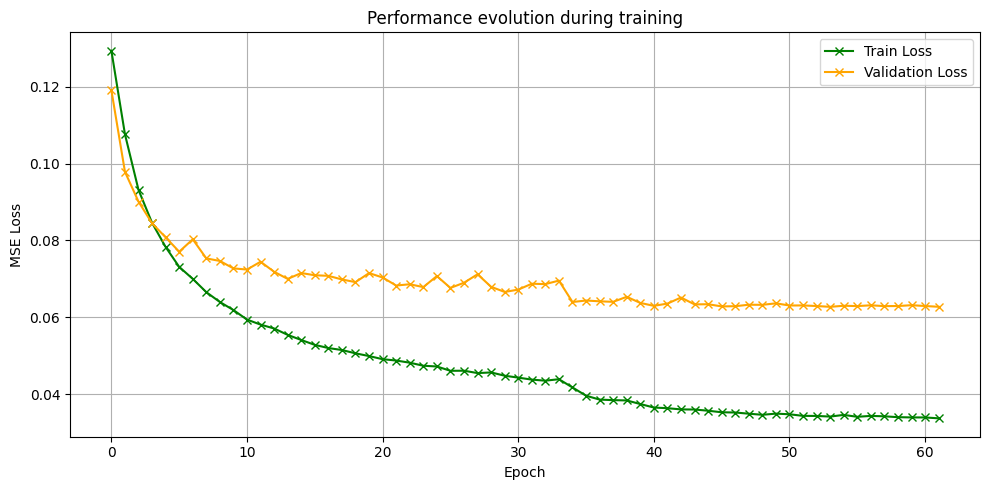

In [70]:
x = np.arange(len(train_losses))
fig = plt.figure(figsize=(10, 5))

# Explained Variance
plt.plot(x, train_losses, label="Train Loss", color="green", marker='x')
# Correlation
plt.plot(x, val_losses, label="Validation Loss", color="orange", marker='x')

plt.title('Performance evolution during training')
plt.xlabel(f"Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

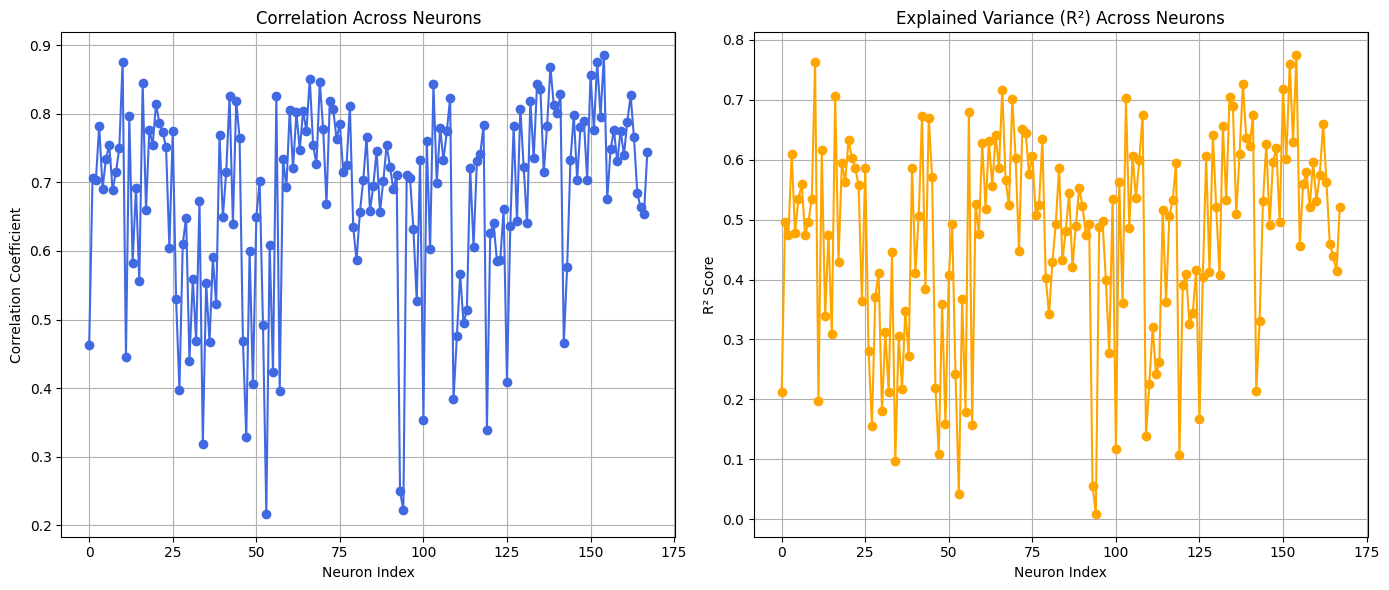

Average Correlation: 0.6783450818807573
Average Explained Variance: 0.47222815241132465


In [73]:
# Predict on validation set
resnet.eval()
all_preds = []
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)
        outputs = resnet(inputs)
        all_preds.append(outputs.cpu().numpy())

y_val_pred = np.vstack(all_preds)
y_val = y_val_tensor.numpy()

# Compute correlation and R²
correlations = [np.corrcoef(y_val[:, i], y_val_pred[:, i])[0, 1] for i in range(y_val.shape[1])]
explained_variance = [explained_variance_score(y_val[:, i], y_val_pred[:, i]) for i in range(y_val.shape[1])]

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(correlations, marker='o', linestyle='-', label='Correlation', color='royalblue')
axs[0].set_title('Correlation Across Neurons')
axs[0].set_xlabel('Neuron Index')
axs[0].set_ylabel('Correlation Coefficient')
axs[0].grid(True)

axs[1].plot(explained_variance, marker='o', linestyle='-', label='Explained Variance', color='orange')
axs[1].set_title('Explained Variance (R²) Across Neurons')
axs[1].set_xlabel('Neuron Index')
axs[1].set_ylabel('R² Score')
axs[1].grid(True)

plt.tight_layout()
plt.show()

print("Average Correlation:", np.nanmean(correlations))
print("Average Explained Variance:", np.nanmean(explained_variance))
